Nama : Salsabila Aulia Putri<br>
NIM : 211351160<br>
Kelas : Malam A

# import Dataset

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salsabilaauliaputri","key":"11a4c1852d1fe2fbe28b7a2723e7d7d6"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [9]:
!kaggle datasets download -d sulmansarwar/transactions-from-a-bakery

  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 53.8MB/s]


In [13]:
!mkdir transactions-from-a-bakery
!unzip transactions-from-a-bakery.zip -d transactions-from-a-bakery
!ls transactions-from-a-bakery

Archive:  transactions-from-a-bakery.zip
  inflating: transactions-from-a-bakery/BreadBasket_DMS.csv  
BreadBasket_DMS.csv


# import library yang digunakan

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
data = pd.read_csv("transactions-from-a-bakery/BreadBasket_DMS.csv")
print("DataFrame shape :",data.shape)
data.head()

DataFrame shape : (21293, 4)


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


# Data Discovery

In [94]:
# format data waktu

data['Date'] = pd.to_datetime(data['Date'], format= "%Y-%m-%d")

In [95]:
data["Date"].dtype

dtype('<M8[ns]')

In [96]:
data["month"] = data['Date'].dt.month
data["day"] = data['Date'].dt.weekday
data.head()

,Date,Time,Transaction,Item,month,day
0,2016-10-30,09:58:11,1,Bread,10,6
1,2016-10-30,10:05:34,2,Scandinavian,10,6
2,2016-10-30,10:05:34,2,Scandinavian,10,6
3,2016-10-30,10:07:57,3,Hot chocolate,10,6
4,2016-10-30,10:07:57,3,Jam,10,6


0 - 6 = Monday - Sunday (Senin - Minggu)

# EDA (minimal 5)

Text(0.5, 1.0, 'jumlah transaksi tiap bulan oktober - april, size = 16')

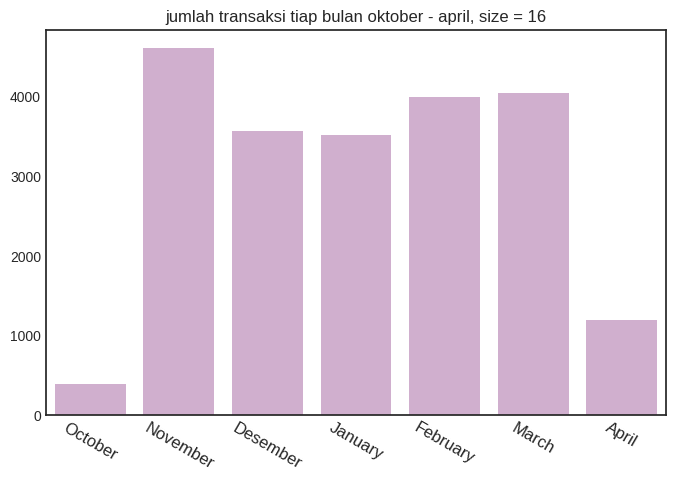

In [97]:
# transaksi tiap bulan

data_perbulan = data.groupby('month')['Transaction'].count()
data_perbulan = pd.concat([data_perbulan.iloc[4:], data_perbulan.iloc[:4]])

plt.figure(figsize= (8,5))
sns.barplot(
    x = ["October", "November", "Desember", "January", "February", "March", "April"],
    y = data_perbulan.values, color="#D5AAD3")
plt.xticks(size = 12, rotation = -30)
plt.title("jumlah transaksi tiap bulan oktober - april, size = 16")

In [38]:
freq = (data['Item'].value_counts())
freq.head()

Coffee    5471
Bread     3325
Tea       1435
Cake      1025
Pastry     856
Name: Item, dtype: int64

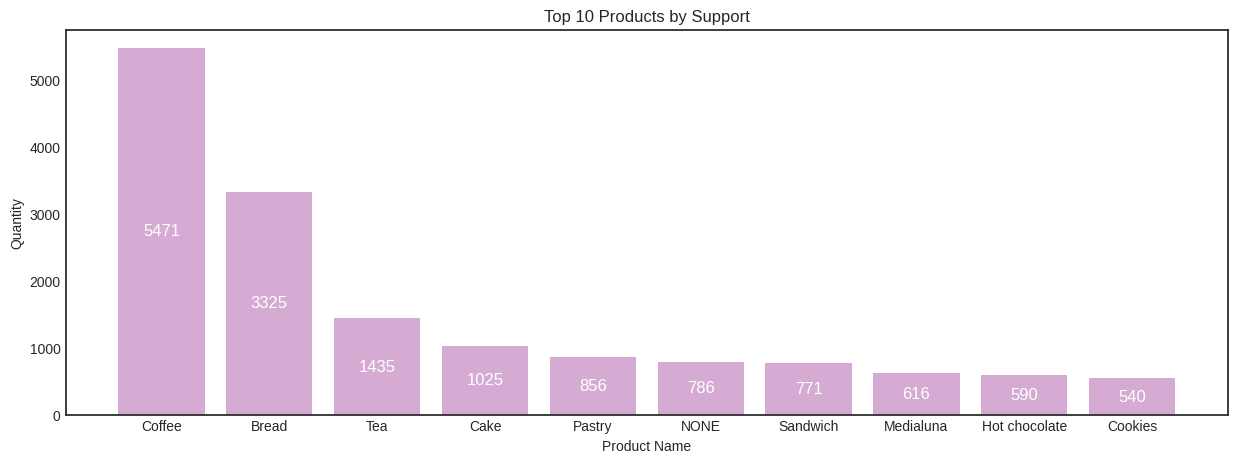

In [98]:
plt.figure(figsize = (15,5))
bars = plt.bar(x = np.arange(len(freq.head(10))), height = (freq).head(10),color='#D5AAD3')
plt.bar_label(bars, fontsize=12, color='white', label_type = 'center')
plt.xticks(ticks = np.arange(len(freq.head(10))), labels = freq.index[:10])

plt.title('Top 10 Products by Support')
plt.ylabel('Quantity')
plt.xlabel('Product Name')
plt.show()

In [99]:
member_shopping_frequency = data.groupby('Transaction')['Item'].count().sort_values(ascending=False)
print(member_shopping_frequency)

Transaction
6474    12
6279    11
6716    11
6412    11
6045    10
        ..
4586     1
4585     1
4584     1
4582     1
9684     1
Name: Item, Length: 9531, dtype: int64


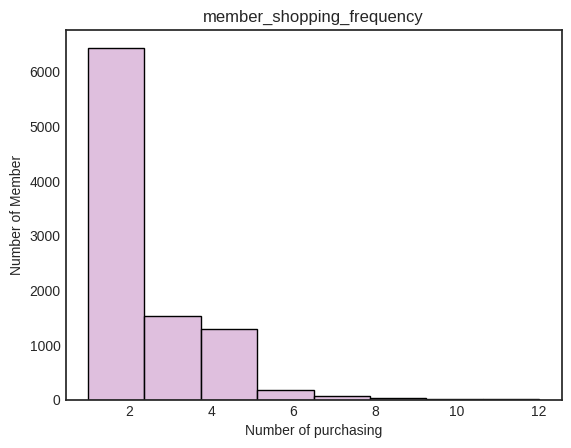

In [100]:
sns.histplot(member_shopping_frequency, bins=8, kde=False,color='#D5AAD3')
plt.xlabel('Number of purchasing')
plt.ylabel('Number of Member')
plt.title('member_shopping_frequency')
plt.show()

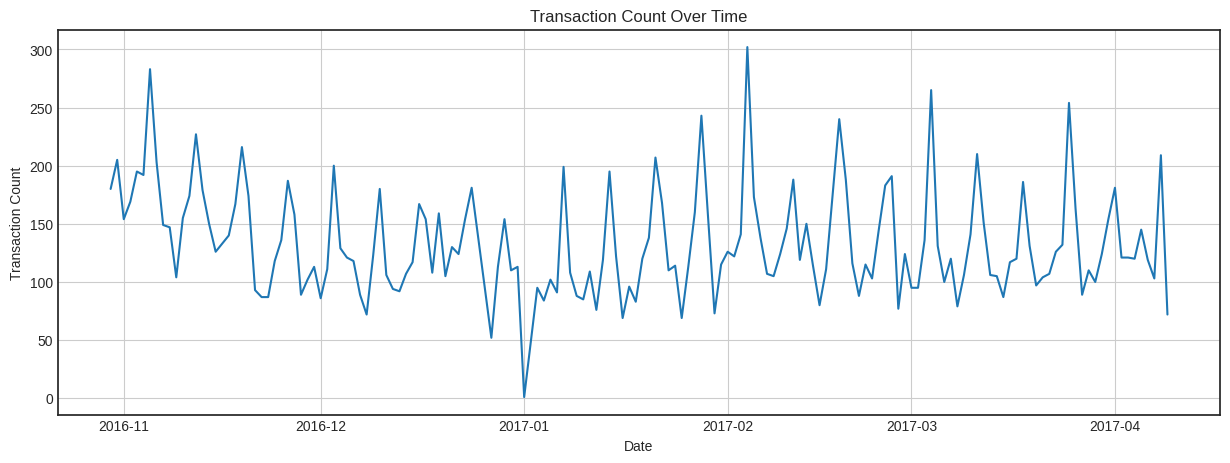

In [106]:
# Group by 'Date' and count the number of transactions
transactions_by_date = data.groupby('Date')['Transaction'].count()

# Plotting the line chart
plt.figure(figsize=(15, 5))
plt.plot(transactions_by_date.index, transactions_by_date.values, linestyle='-')

plt.title('Transaction Count Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.grid(True)
plt.show()

In [112]:
data.head()

,Date,Time,Transaction,Item,month,day
0,2016-10-30,09:58:11,1,Bread,10,6
1,2016-10-30,10:05:34,2,Scandinavian,10,6
2,2016-10-30,10:05:34,2,Scandinavian,10,6
3,2016-10-30,10:07:57,3,Hot chocolate,10,6
4,2016-10-30,10:07:57,3,Jam,10,6


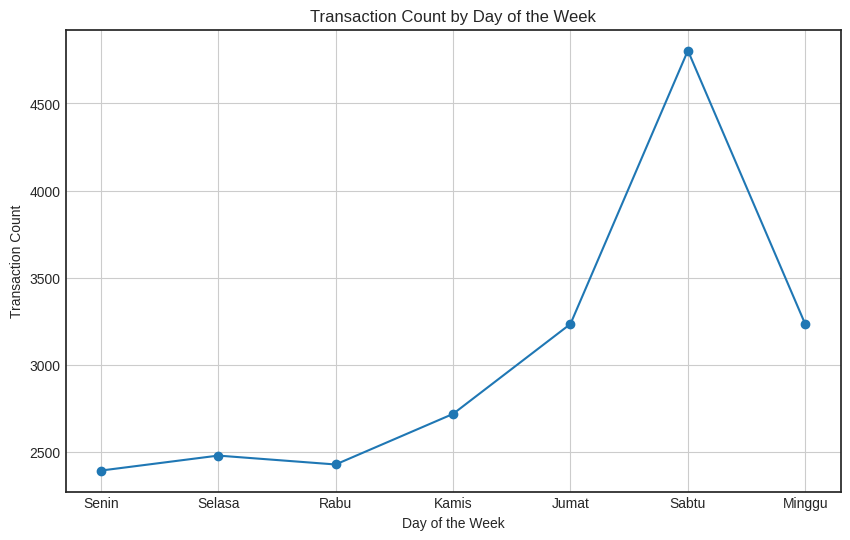

In [114]:
transactions_by_day = data.groupby('day')['Transaction'].count()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(transactions_by_day.index, transactions_by_day.values, marker='o', linestyle='-')

# Labeling the chart
plt.title('Transaction Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')
plt.xticks(range(7), ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])

plt.grid(True)
plt.show()

8240

# Preprocessing

In [ ]:
## data preparation

In [59]:
data["Item"] = data["Item"].apply(lambda item: item.lower())

In [60]:
data["Item"] = data["Item"].apply(lambda item: item.strip())

In [61]:
data = data[["Transaction", "Item"]].copy()
data.head()

,Transaction,Item
0,1,bread
1,2,scandinavian
2,2,scandinavian
3,3,hot chocolate
4,3,jam


In [1]:
from mlxtend.frequent_patterns import association_rules, apriori

# modeling

In [16]:
item_count = data.groupby(["Transaction", "Item"])["Item"].count().reset_index(name="Count")
item_count.head(10)

,Transaction,Item,Count
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1
5,4,Muffin,1
6,5,Bread,1
7,5,Coffee,1
8,5,Pastry,1
9,6,Medialuna,1


In [18]:
item_count_pivot = item_count.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
print("ukuran Dataset :", item_count_pivot.shape)
item_count_pivot.head()

ukuran Dataset : (9531, 95)


Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,Fudge,Gift voucher,Gingerbread syrup,Granola,Hack the stack,Half slice Monster,Hearty & Seasonal,Honey,Hot chocolate,Jam,Jammie Dodgers,Juice,Keeping It Local,Kids biscuit,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,NONE,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
item_count_pivot = item_count_pivot.astype("int32")
item_count_pivot.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,Fudge,Gift voucher,Gingerbread syrup,Granola,Hack the stack,Half slice Monster,Hearty & Seasonal,Honey,Hot chocolate,Jam,Jammie Dodgers,Juice,Keeping It Local,Kids biscuit,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,NONE,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
def encode(x):
  if x <=0:
    return 0
  elif x >=1:
    return 1

item_count_pivot = item_count_pivot.applymap(encode)
item_count_pivot.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,Fudge,Gift voucher,Gingerbread syrup,Granola,Hack the stack,Half slice Monster,Hearty & Seasonal,Honey,Hot chocolate,Jam,Jammie Dodgers,Juice,Keeping It Local,Kids biscuit,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,NONE,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
print("Ukuran dataset : ", item_count_pivot.shape)
print("Jumlah Transaksi : ", item_count_pivot.shape[0])
print("Jumlah items :", item_count_pivot.shape[1])

Ukuran dataset :  (9531, 95)
Jumlah Transaksi :  9531
Jumlah items : 95


In [22]:
support = 0.01
frequent_items = apriori(item_count_pivot, min_support= support, use_colnames=True)
frequent_items.sort_values("support", ascending=False).head(10)

,support,itemsets
6,0.475081,(Coffee)
2,0.324940,(Bread)
27,0.141643,(Tea)
4,0.103137,(Cake)
35,0.089393,"(Coffee, Bread)"
20,0.085510,(Pastry)
19,0.079005,(NONE)
22,0.071346,(Sandwich)
16,0.061379,(Medialuna)
12,0.057916,(Hot chocolate)


In [25]:
metric = "lift"
min_threshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_threshold)[["antecedents","consequents","support","confidence","lift"]]
rules.sort_values('confidence', ascending=False, inplace=True)
rules.head(15)

,antecedents,consequents,support,confidence,lift
33,(Toast),(Coffee),0.023502,0.704403,1.482699
31,(Spanish Brunch),(Coffee),0.010807,0.598837,1.260494
19,(Medialuna),(Coffee),0.034939,0.569231,1.198175
25,(Pastry),(Coffee),0.047214,0.552147,1.162216
1,(Alfajores),(Coffee),0.019515,0.540698,1.138116
17,(Juice),(Coffee),0.020460,0.534247,1.124537
23,(NONE),(Coffee),0.042073,0.532537,1.120938
27,(Sandwich),(Coffee),0.037981,0.532353,1.120551
7,(Cake),(Coffee),0.054349,0.526958,1.109196
29,(Scone),(Coffee),0.017941,0.522936,1.100729


# Visualisasi hasil algoritma

<ipython-input-28-b708574fa54e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


<Axes: xlabel='confidence', ylabel='lift'>

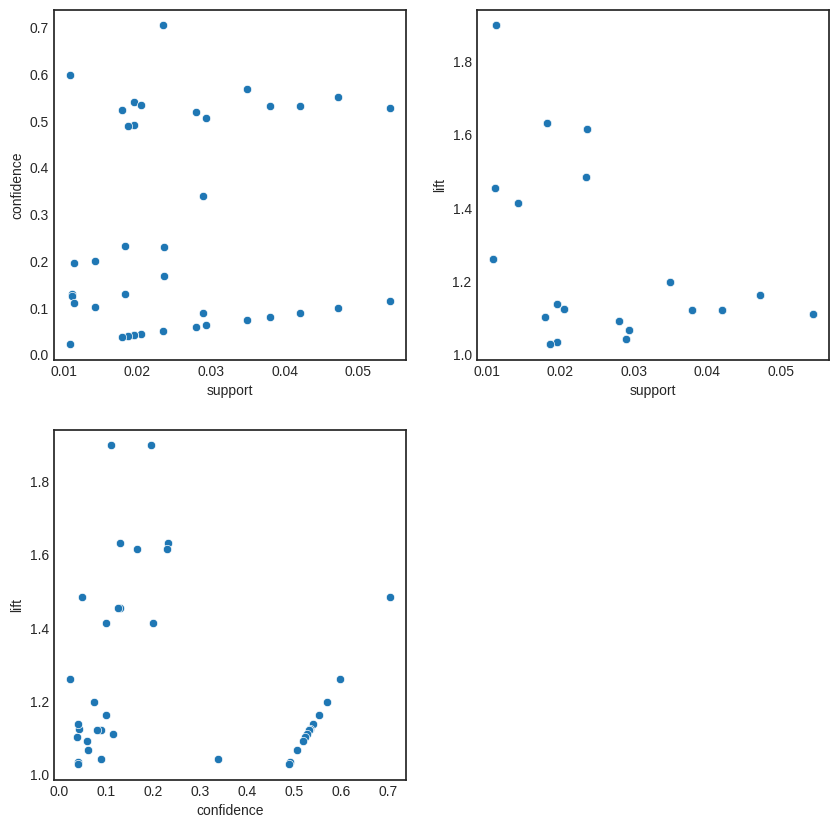

In [28]:
plt.figure(figsize = (10, 10))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules)

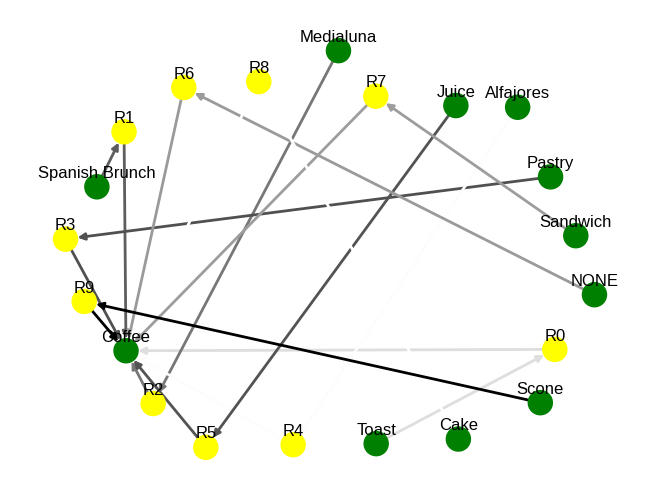

In [30]:
def draw_graph(rules, rules_to_show):
  import networkx as nx
  G1 = nx.DiGraph()

  color_map=[]
  N = 50
  colors = np.random.rand(N)
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']


  for i in range (rules_to_show):
    G1.add_nodes_from(["R"+str(i)])


    for a in rules.iloc[i]['antecedents']:

        G1.add_nodes_from([a])

        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

    for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([a])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

  for node in G1:
       found_a_string = False
       for item in strs:
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')

  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)

  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

#Calling function with 10 rules
draw_graph(rules, 10)

# save model (pickle)

In [ ]:
code 1

In [ ]:
code 2

In [ ]:
code 3